<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP10</h2></center>

# Importation des librairies

In [1]:
!pip install transformers
!pip install torch
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Importation du dataset

In [ ]:
dataset = load_dataset("imdb")

train_texts, test_texts, train_labels, test_labels = train_test_split(dataset["train"]["text"], dataset["train"]["label"], test_size=0.2, random_state=42)

# Prétraitement des données

## importation du tokenizer pour le prétraitement des données

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## tokenisation des données

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

## Mettre le training et testing set au format adapté pour le modèle

In [ ]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)

# Initialisation du modèle BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Entrainement du modèle

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 3
count = 0
for epoch in range(num_epochs):
  model.train()
  for batch in train_loader:
    if count < 25:
      inputs, attention_mask, labels = batch
      outputs = model(inputs, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    count += 1

# Test du modèle 

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model.eval()
correct, total, count = 0, 0
with torch.no_grad():
  for batch in test_loader:
    inputs, attention_mask, labels = batch
    outputs = model(inputs, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1)
    correct += (predictions == labels).sum().item()
    total += len(labels)

acc =  correct / total
print(f"Accuracy on test set:  {acc * 100:.2f} %")

Accuracy on test set: 82.00 %


# Visualisation des résultats

Text(70.72222222222221, 0.5, 'True')

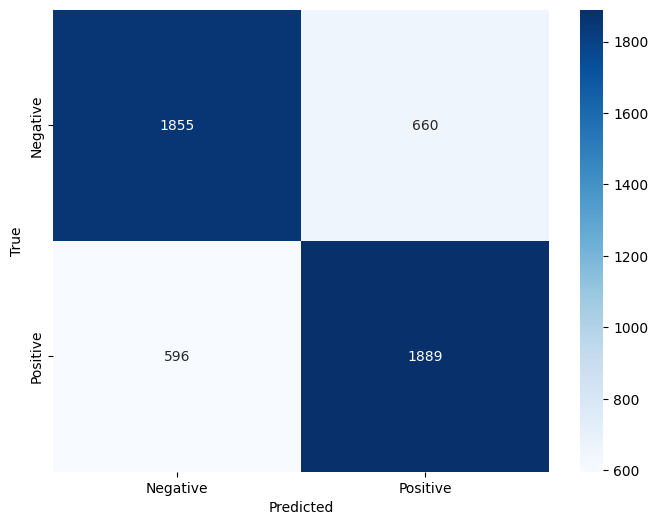

In [ ]:
model.eval()
predictions_list = []
true_labels_list = []
with torch.no_grad():
  for batch in test_loader:
    inputs, attention_mask, labels = batch
    outputs = model(inputs, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1)
    predictions_list.extend(predictions.cpu().numpy())
    true_labels_list.extend(labels.cpu().numpy())

cm = confusion_matrix(true_labels_list, predictions_list)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')